Reference: 
* https://www.kaggle.com/code/springboardroger/naive-bayes-name-gender-classifier
* https://www.kaggle.com/code/ynouri/random-forest-k-fold-cross-validation 

Here, we import all of the needed libraries. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
import requests
from bs4 import BeautifulSoup
import matplotlib
matplotlib.use("TKAgg")
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
matplotlib.rcParams.update({'font.family': "Open Sans", 'font.size': 16})


In [2]:
import helper

## Exploratory Data Analysis

Now we import the data file (the Social Security database) and do some basic data cleaning -- so we can display the first five entries and get a sense of the data.

In [3]:
#import social security names database from Kaggle in int form
names = pd.read_csv("data/name_gender.csv")
# names = names.fillna("")
names["name"] = names["name"].apply(lambda x: x.lower())
names


,name,gender
0,aaban&&,M
1,aabha*,F
2,aabid,M
3,aabriella,F
4,aada_,F
...,...,...
95020,zyvion,M
95021,zyvon,M
95022,zyyanna,F
95023,zyyon,M


In [4]:
names.isnull().groupby("name").count()


,gender
name,
False,95025


In [5]:
names.isnull().groupby("gender").count()


,name
gender,
False,95025


no missing data for each row

### Check non-alphabetic character

In [6]:
names["is_alphabet"] = names["name"].apply(helper.is_alphabet)
names[names["is_alphabet"] == False]

,name,gender,is_alphabet
0,aaban&&,M,False
1,aabha*,F,False
4,aada_,F,False
10,aadhav+,M,False
13,aadhira4,F,False
...,...,...,...
94826,zyair770,M,False
94874,zyheir887,M,False
94915,zykir24,M,False
94957,zymirah11,F,False


there are punctuation and number from names that should be removed

## Data Cleaning

* Lowercase
* Remove Punctuation
* Remove Number
 

In [7]:
names["name"] = names.apply(lambda row: helper.remove_punctuation(row["name"].lower()), axis=1)
names["name"] = names.apply(lambda row: helper.remove_number(row["name"]), axis=1)
names

,name,gender,is_alphabet
0,aaban,M,False
1,aabha,F,False
2,aabid,M,True
3,aabriella,F,True
4,aada,F,False
...,...,...,...
95020,zyvion,M,True
95021,zyvon,M,True
95022,zyyanna,F,True
95023,zyyon,M,True


Now let's groupby so we can get away from counting, and get the aggregated count of female and male occurrences for each name.

In [8]:
names.groupby(['name', 'gender']).size().reset_index(name='count').sort_values(by=["count", "name", "gender"])


,name,gender,count
0,aaban,M,1
1,aabha,F,1
2,aabid,M,1
3,aabriella,F,1
4,aada,F,1
...,...,...,...
95020,zyvion,M,1
95021,zyvon,M,1
95022,zyyanna,F,1
95023,zyyon,M,1


Each name is unique and only has one occurence in the dataset. Since each name only has 1 occurence, there is not any frequency information of a specific name.

### Gender Distribution

In [9]:
names.groupby(['gender']).count()


,name,is_alphabet
gender,,
F,60304,60304
M,34721,34721


The number of females name almost 2x time higher than the number of male names. 
Thus, during inferencing, it's better to give female prediction as the ouput when the queried name is not exist in the training data. 

### Name Length

In [10]:
names["length"] = names["name"].apply(len)
names


,name,gender,is_alphabet,length
0,aaban,M,False,5
1,aabha,F,False,5
2,aabid,M,True,5
3,aabriella,F,True,9
4,aada,F,False,4
...,...,...,...,...
95020,zyvion,M,True,6
95021,zyvon,M,True,5
95022,zyyanna,F,True,7
95023,zyyon,M,True,5


In [11]:
names[names["gender"] == "F"].groupby("length").count()


,name,gender,is_alphabet
length,,,
2,48,48,48
3,367,367,367
4,2505,2505,2505
5,8848,8848,8848
6,15914,15914,15914
7,17155,17155,17155
8,10087,10087,10087
9,3806,3806,3806
10,1093,1093,1093


In [12]:
names[names["gender"] == "M"].groupby("length").count()


,name,gender,is_alphabet
length,,,
2,100,100,100
3,584,584,584
4,2684,2684,2684
5,7114,7114,7114
6,10522,10522,10522
7,7521,7521,7521
8,3584,3584,3584
9,1461,1461,1461
10,605,605,605


findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


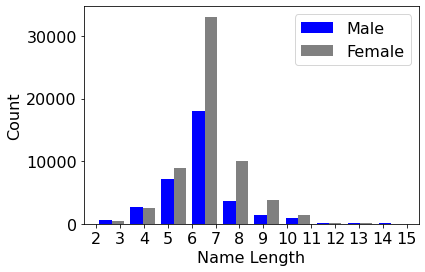

In [13]:
import matplotlib.pyplot as plt

male_lengths = names[names["gender"] == "M"]["length"]
female_lengths = names[names["gender"] == "F"]["length"]

plt.hist([male_lengths, female_lengths], color=[
         'Blue', 'Grey'], label=['Male', 'Female'])
plt.xlabel('Name Length')
plt.xticks(range(2,16))
plt.ylabel('Count')
plt.legend()
plt.show()

## Feature Representation

### Bag of Words
Machine learning models don't learn from raw text data. Instead, you need to convert the text to something numeric.

The simplest common representation is a variation of one-hot encoding. You represent each document as a vector of term frequencies for each term in the vocabulary. The vocabulary is built from all the tokens (terms) in the corpus (the collection of documents). 

As an example, take the sentences "Tea is life. Tea is love." and "Tea is healthy, calming, and delicious." as our corpus. The vocabulary then is `{"tea", "is", "life", "love", "healthy", "calming", "and", "delicious"}` (ignoring punctuation).

For each document, count up how many times a term occurs, and place that count in the appropriate element of a vector. The first sentence has "tea" twice and that is the first position in our vocabulary, so we put the number 2 in the first element of the vector. Our sentences as vectors then look like 

$$
\begin{align}
v_1 &= \left[\begin{matrix} 2 & 2 & 1 & 1 & 0 & 0 & 0 & 0 \end{matrix}\right] \\
v_2 &= \left[\begin{matrix} 1 & 1 & 0 & 0 & 1 & 1 & 1 & 1 \end{matrix}\right]
\end{align}
$$

This is called the **bag of words** representation. You can see that documents with similar terms will have similar vectors. Vocabularies frequently have tens of thousands of terms, so these vectors can be very large.

Another common representation is **TF-IDF (Term Frequency - Inverse Document Frequency)**. TF-IDF is similar to bag of words except that each term count is scaled by the term's frequency in the corpus. Using TF-IDF can potentially improve your models. You won't need it here. Feel free to look it up though!


#### Bi-gram analysis

<AxesSubplot:>

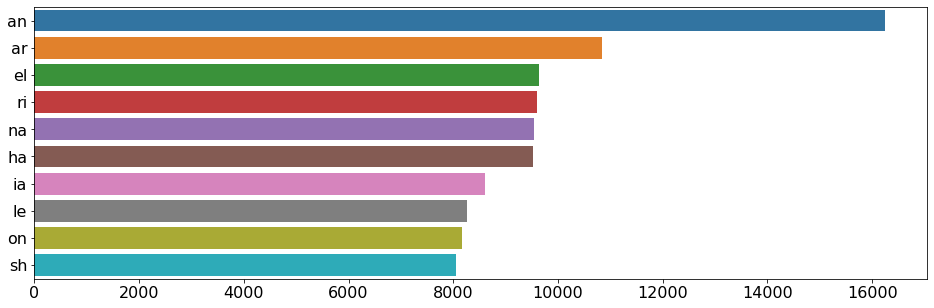

In [14]:
def get_top_bigrams(corpus, n=None):
    vec = CountVectorizer(analyzer='char', ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]


plt.figure(figsize=(16, 5))
top_tweet_bigrams = get_top_bigrams(names['name'])[:10]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x)


<AxesSubplot:>

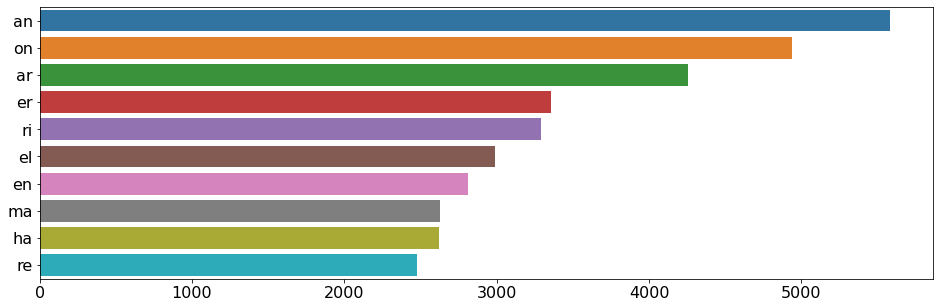

In [15]:
male_names = names[names['gender']=="M"]['name']

plt.figure(figsize=(16, 5))
top_tweet_bigrams = get_top_bigrams(male_names)[:10]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x)


<AxesSubplot:>

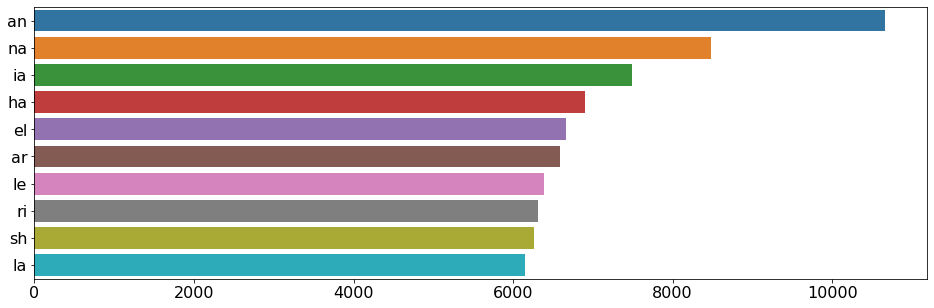

In [16]:
female_names = names[names['gender'] == "F"]['name']

plt.figure(figsize=(16, 5))
top_tweet_bigrams = get_top_bigrams(female_names)[:10]
x, y = map(list, zip(*top_tweet_bigrams))
sns.barplot(x=y, y=x)


### Bigram Feature

In [17]:
def countvect(data):
    count_vectorizer = CountVectorizer(analyzer='char', ngram_range=(2, 2))

    emb = count_vectorizer.fit_transform(data)

    return emb, count_vectorizer


cv_feature, count_vectorizer = countvect(names["name"])
# count_vectorizer.get_feature_names()


In [18]:
print(cv_feature.toarray())
print(cv_feature.toarray()[0])


[[1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 [1 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 1 1 1]]
[1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

### TF-IDF

In [19]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer(analyzer='char', ngram_range=(2, 2))

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer


tfidf_features, tfidf_vectorizer = tfidf(names["name"])


In [20]:
# print(tfidf_feature.toarray())
print(tfidf_features.toarray()[0])


[0.55234753 0.53014961 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.28388006 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.5772917  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         

In [21]:
print(len(tfidf_features.toarray()[0]))
print(len(tfidf_vectorizer.get_feature_names()))


618
618


In [22]:
X = pd.DataFrame(data=tfidf_features.toarray(), columns=tfidf_vectorizer.get_feature_names())

In [23]:
y = names["gender"].apply(lambda x : 1 if x == "M" else 0)

## Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, auc


In [25]:
clf = RandomForestClassifier(
    n_estimators=700,
    criterion='gini',
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=0,
    verbose=0,
    warm_start=False,
    class_weight='balanced'
)


In [26]:
def plot_roc_curve(fprs, tprs):
    """Plot the Receiver Operating Characteristic from a list
    of true positive rates and false positive rates."""
    
    # Initialize useful lists + the plot axes.
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(14,10))
    
    # Plot ROC for each K-Fold + compute AUC scores.
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs)):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))
        
    # Plot the luck line.
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Luck', alpha=.8)
    
    # Plot the mean ROC.
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)
    
    # Plot the standard deviation around the mean ROC.
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')
    
    # Fine tune and show the plot.
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic')
    ax.legend(loc="lower right")
    plt.show()
    return (f, ax)

def compute_roc_auc(index):
    y_predict = clf.predict_proba(X.iloc[index])[:,1]
    fpr, tpr, thresholds = roc_curve(y.iloc[index], y_predict)
    auc_score = auc(fpr, tpr)
    return fpr, tpr, auc_score

findfont: Font family ['Open Sans'] not found. Falling back to DejaVu Sans.


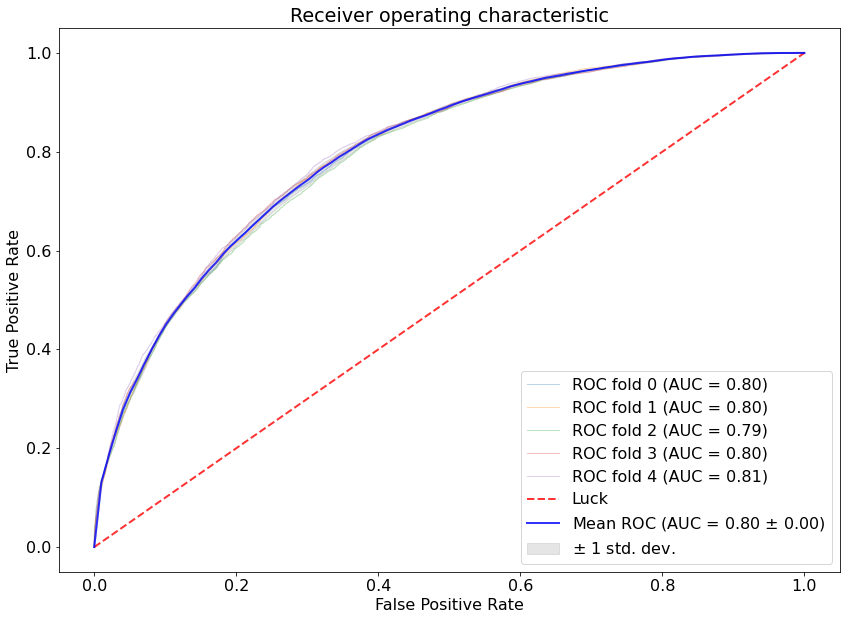

,AUC Train,AUC Test
0,0.806533,0.799430
1,0.806043,0.800571
2,0.807197,0.794996
3,0.806582,0.802402
4,0.805788,0.806304


In [27]:
cv = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
results = pd.DataFrame(columns=['training_score', 'test_score'])
fprs, tprs, scores = [], [], []

for (train, test), i in zip(cv.split(X, y), range(5)):
    clf.fit(X.iloc[train], y.iloc[train])
    _, _, auc_score_train = compute_roc_auc(train)
    fpr, tpr, auc_score = compute_roc_auc(test)
    scores.append((auc_score_train, auc_score))
    fprs.append(fpr)
    tprs.append(tpr)

plot_roc_curve(fprs, tprs)
pd.DataFrame(scores, columns=['AUC Train', 'AUC Test'])
